In [9]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn import svm
from skimage.feature import greycomatrix, greycoprops
from sklearn import metrics
import seaborn as sns
import pandas as pd

## Read Data

In [10]:
%run Read_Data.ipynb

## Extract Features

In [11]:
# -----------------------------------------------------------------------------
# From https://gist.github.com/viveksck/1110dfca01e4ec2c608515f0d5a5b1d1
# Applies https://en.wikipedia.org/wiki/Minkowski–Bouligand_dimension:
# -----------------------------------------------------------------------------

def TTBD(img, t1, t2):                      # Two Threshold Binary Deomposition
    img = (t1 <= img) & (t2 >= img)
    return img


def get_fractal_dimension(img):                                 # Takes a binary image and returns its fractal dimension.

    # Slice image at multiples of k and add  pixels in each
    def boxcount(img, k):
        vertical_slices = np.add.reduceat(img, np.arange(0, img.shape[0], k), axis=0)
        boxCounts = np.add.reduceat( vertical_slices, np.arange(0, img.shape[1], k), axis=1)    # horizontal slice
        return len(np.where((boxCounts > 0) & (boxCounts < k*k))[0])        # How many boxes are not empty and not full (partial boxes)

    # Smaller dimension of image
    p = min(img.shape)

    # Largest n for which 2^n <= p
    n = int(np.floor(np.log2(p)))
   
    # Build successive box sizes (from 2**n down to 2**1)
    box_sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    partial_box_counts = [boxcount(img, box_size) for box_size in box_sizes]

    # Approximate the relation between log(box_sizes) and log(partial_box_counts) 
    # Then return the fractal dimension as the log partial box counts for very small box_sizes (np.log(box_sizes)=0), box_sizes=1
    coeffs = np.polyfit(np.log(box_sizes), np.log(partial_box_counts), 1)
    return -coeffs[0] if coeffs[0]==coeffs[0] else 0.0

def fractal_test():
    img = cv2.imread("./Misc/sierpinski.png", 0)
    t = np.mean(img.flatten(), axis=0)
    img = img < t

    print("Minkowski–Bouligand dimension (computed): ", get_fractal_dimension(img))
    print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))


def SFTA(img, T):                         #Segmentation-based Fractal Analysis as in the paper: takes img and threshold array.
    silhouettes = []
    T.append(np.amax(img))
    for t1, t2 in zip(T, T[1:]):         # Apply two-threshold binary decomposition on the image using each two consequtive thresholds.
        silhouettes.append(TTBD(img, t1, t2))

    T.pop()
    for t in T:                         # Apply two-threshold binary decomposition on the image using each threshold and the max value
        silhouettes.append(TTBD(img, t, np.amax(img)))

    fractal_vector = [ get_fractal_dimension(sil) for sil in silhouettes ]      # 2*len(T) Binary Images => Fractal Dimension for each.
    mean_vector = [np.mean(sil) for sil in silhouettes]                         # Get mean of each as well
    size_vector = [img.shape[0]*img.shape[1]]                                   # Now Have 4*len(T) + 1 features
    
    return fractal_vector + mean_vector + size_vector

img = cv2.imread("./CMP23-Dataset/Female/F12.jpg", 0)
opt_t,_ = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#fractal_test()


In [12]:
# converting the dataset into features (x1, x2)
def apply_features(x_train, x_test, saved=False):
   if saved:
      with open('./Feature-Datasets/fractal.npy', 'rb') as f:
         x_train = np.load(f, allow_pickle=True)
         x_test = np.load(f, allow_pickle=True)
   else:
      T = [opt_t * 0.3, opt_t * 0.8, opt_t, opt_t * 1.1 ]
      x_train = np.array([SFTA(img, T) for img in x_train])
      x_test = np.array([SFTA(img, T) for img in x_test])
      with open('./Feature-Datasets/fractal.npy', 'wb') as f:
         np.save(f, x_train, allow_pickle=True)
         np.save(f, x_test, allow_pickle=True)
   return x_train, x_test

x_train, x_test = apply_features(x_train, x_test, saved=True)

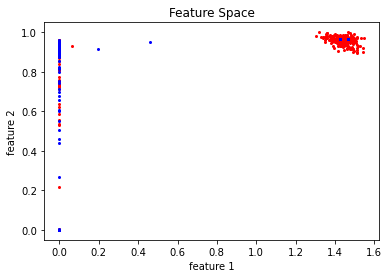

In [13]:
# Generate scatter plot for training data 
x_train_male = x_train[y_train == 0]
x_train_female = x_train[y_train == 1]
plt.scatter(x_train_male[:,7], x_train_male[:,13], color='red', s=4)
plt.scatter(x_train_female[:,7], x_train_female[:,13], color='blue', s=4)
plt.title('Feature Space')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()


/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_7511/3545554625.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


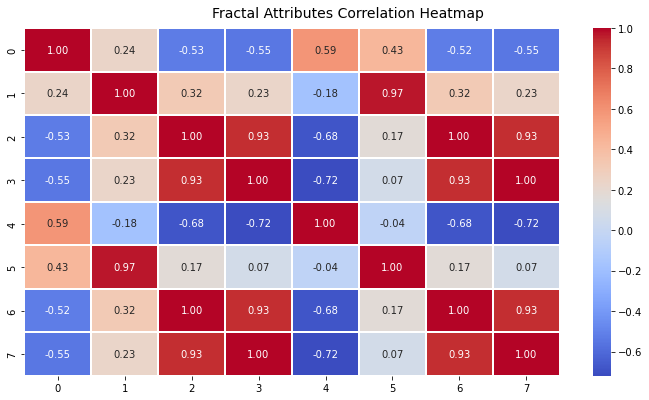

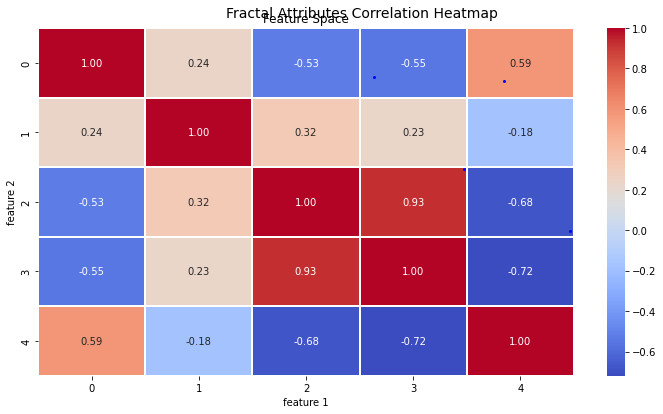

In [14]:

def heat_map(x_pd):
   f, ax = plt.subplots(figsize=(12, 6))
   corr = x_pd.corr()
   hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                  linewidths=.05)
   f.subplots_adjust(top=0.93)
   t= f.suptitle('Fractal Attributes Correlation Heatmap', fontsize=14)


def corr_kill(x1_pd, x2_pd=[]):
   corr_matrix = x1_pd.corr().abs()

   # Select upper triangle of correlation matrix
   upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

   # Find features with correlation greater than 0.95
   to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

   # Drop features 
   x1_pd.drop(to_drop, axis=1, inplace=True)
   if len(x2_pd):
      x2_pd.drop(to_drop, axis=1, inplace=True)

   return x1_pd, x2_pd

x_train_pd = pd.DataFrame(x_train[:,0:8])

heat_map(x_train_pd)

x_train_pd, x_test_pd = corr_kill(x_train_pd, pd.DataFrame(x_test[:,0:8]))

heat_map(x_train_pd)

x_train_filtered = x_train_pd.to_numpy()
x_test_filtered = x_test_pd.to_numpy()
